# Lab 5: Basketball Salaries

### Instructions:
- perform a fresh `restart & run all` before submitting the `.ipynb` to [gradescope](https://www.gradescope.com/courses/478298)
- [lab rubric](https://course.ccs.neu.edu/ds2500/admin_syllabus.html?highlight=rubric#weekly-lab-ds-2501)
- work in groups of 2-5
- be collaborative and kind
    - ask questions of others
    - invite questions from others
- each student will submit their own lab file
- please do not share code files 
    - however, unlike HW, you're welcome to look at each other's ungraded work
    
   
You've already seen [this video](https://youtu.be/SiovCeiKuSY) on hw5 for an "introduction" to `RandomForestRegressor`s.  But we share it here again in case its helpful.

## Data Source:

Spend a few moments examining the linked sources to study any relevant information for your analysis below. 

- player stats taken from [source](https://www.basketball-reference.com/leagues/NBA_2022_per_poss.html) (2021-2022 season)
    - note that many features are normalized per 100 possessions
        - examine this source for description of each feature 
            - see "glossary"
            - hover mouse over header of data table to see which is normalized per 100 possessions
- salaries taken from [source](https://www.basketball-reference.com/contracts/players.html) (2022-2023 season)

Note that some players appeared twice in these intial datasets (they were traded and have a unique row for every team they played for this season).  These players have been removed from the dataset.

# Introduction: Predicting NBA player salary from on-court statistics

Why do some NBA players get paid more than others?  Is it because they are defensive stalwarts whose rebounds, blocks and steals (REB, BLK, STL) are so impressive.  Or maybe the players who get paid the most are masterful on the other end of the court, scoring more points, with higher shooting percentages (PTS, FG)?

To answer this question, we'll build a regression model which predicts salary from on-court statistics.

In [1]:
import pandas as pd

df = pd.read_csv('nba_prepped.csv', index_col='player_id')

df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,salary2022-2023_mill
player_id,,,,,,,,,,,,,,,,,,,,,
achiupr01,Precious Achiuwa,C,22,TOR,73,28,1725,7.7,17.5,0.439,...,13.7,2.4,1.1,1.2,2.4,4.4,19.2,105.0,110,2.840160
adamsst01,Steven Adams,C,28,MEM,76,75,1999,5.0,9.2,0.547,...,18.2,6.1,1.6,1.4,2.8,3.7,12.6,125.0,108,17.926829
adebaba01,Bam Adebayo,C,24,MIA,56,56,1825,11.1,20.0,0.557,...,15.5,5.2,2.2,1.2,4.1,4.7,29.3,117.0,104,30.351780
aldamsa01,Santi Aldama,PF,21,MEM,32,0,360,7.0,17.5,0.402,...,11.6,2.8,0.8,1.3,2.1,4.8,17.5,101.0,111,2.094120
allengr01,Grayson Allen,SG,26,MIL,66,61,1805,6.8,15.1,0.448,...,5.9,2.7,1.2,0.5,1.1,2.6,19.5,122.0,114,8.500000


# Part A: Building Decision Tree Regressor

1. Build a `DecisionTreeRegressor` which:
    - has target feature `salary2022-2023_mill`
    - has input features `x_feat_list = df.columns[7: -1]`
    - has `max_depth = 2`
    - do not cross validate
1. Plot the decision tree
1. Predict the salary of a player:
    - whose team score 31 points per 100 team possessions
    - whose team attempts 4 free throws per 100 team possessions
    - (write your answer in one complete sentence in a markdown cell directly below the table)

In [2]:
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

In [3]:
def train_dec_tree(df, max_depth=2, x_feat_list=None):
    """ trains a decision tree regressor, prints graph
    
    Args:
        df (pd.DataFrame): players 
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input features
        
    Returns:
        dec_tree_reg (DecisionTreeRegressors): trained decicision tree
    """
    
    x_feat_list = df.columns[7: -1]

    # extract data from dataframe
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, 'salary2022-2023_mill'].values
    
    # build decision tree regressor
    dec_tree_reg = tree.DecisionTreeRegressor(max_depth=max_depth)

    # fit data
    dec_tree_reg = dec_tree_reg.fit(x, y)
    
    return dec_tree_reg

In [4]:
def plot_tree(train_dec_tree):
    """ plot decision tree """
    
    x_feat_list = df.columns[7: -1]
    
    plt.figure()
    plt.gcf().set_size_inches(15, 10)
    sns.set(font_scale=1.5)
    plt.suptitle("Salary Decision Tree")
    
    # 'plot' decision tree
    tree.plot_tree(train_dec_tree, 
                       feature_names=x_feat_list);

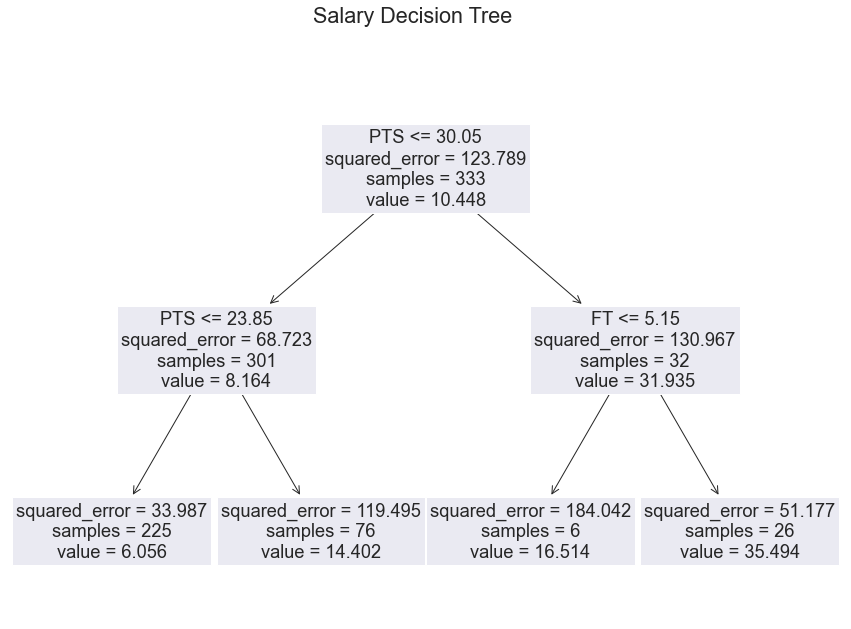

In [5]:
# plot
plot_tree(train_dec_tree(df, max_depth=2))

### <font color=royalblue> Response: </font> 

Predict the salary of a player:
- whose team score 31 points per 100 team possessions
- whose team attempts 4 free throws per 100 team possessions

A player who is on a team that scores 31 points with 4 free throws has a salary of 16.514 million.

# Part B: Ensuring the Random Forest Regressor Works

We'd like to use a `RandomForestRegressor` in a feature importance analysis to identify:

    Which on-court-statistics are responsible for a player being paid more (or less)?
    
We'll perform this analysis in Part C, but before identifying which features are important we should check that our regression model works.  (Nobody cares which features are improtant in a regression model which can't predict accurately!)

1. Compute a cross validated $R^2$ value for a `RandomForestRegressor` with:
    - max_depth = 5
    - same x, y values as above
1. Interpret the cross-validated $R^2$ for a layman in one markdown sentence.  Does the regressor identify some relationship between all x features and y worth investigating further?

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from copy import copy

In [7]:
x = df.loc[:, df.columns[7: -1]].values
y = df.loc[:, 'salary2022-2023_mill'].values

In [8]:
#kfold 
kfold = KFold(n_splits=10, shuffle=True)

# regressor
regressor = RandomForestRegressor(max_depth = 5)

# initalized y_pred
y_pred = copy(y)

for train_idx, test_idx in kfold.split(x, y):
    # training data
    x_train = x[train_idx,:]
    y_train = y[train_idx]
    
    # testing data
    x_test = x[test_idx]
    
    # fit 
    regressor.fit(x_train, y_train)

    # predict
    y_pred[test_idx] = regressor.predict(x_test)

In [9]:
r2 = r2_score(y_true=y, y_pred=y_pred)
r2

0.4632836742254146

### <font color=royalblue> Response: </font> 

The cross-validated $R^2$ for a layman is 46.33%, which shows that roughly 46% of the variations are explained by the model, and this number also indicates a moderate correlation (not a strong one) between the x features and y-value. 

# Part C: Feature Importance

1. Fit the `RandomForestRegressor` on the whole dataset (no cross validation here)
1. Build a feature importance graph which shows how much Mean Squared Error is reduced by each feature
    - use `plot_feat_import()` from day 14 of class notes
        - be sure its `plt.xlabel` is appropriate in this context
        - avoid using the `limit` argument, there's a slight bug
            - see Part D
1. Write one or two sentences which summarize your analysis for a layman.

In [10]:
def plot_feat_import(feat_list, feat_import, sort=True):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n (Mean % decreases in R^2 due to different features)')

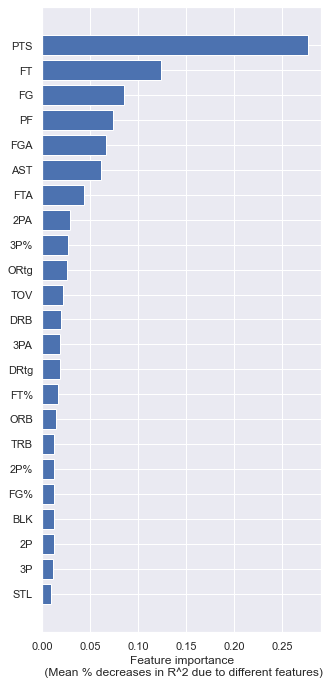

In [11]:
import numpy as np
import seaborn as sns
x_feat_list = df.columns[7: -1]

# extract data from dataframe
x = df.loc[:, x_feat_list].values
y = df.loc[:, 'salary2022-2023_mill'].values

rfreg = RandomForestRegressor()
rfreg.fit(x, y)

sns.set()

plot_feat_import(x_feat_list, rfreg.feature_importances_)


### <font color=royalblue> Response: </font> 

Based on the chart above, the most important features that determine the salary are PTS (total points), FT (freethrows), and FGA (field goal attemps).

# Extra Credit (++)

- (+.1) Fix the `limit` parameter so it can be properly used in this application
    - include one or two sentences which explain the bug in the version in class in addition to fixing and using in your own code
    
## To prepare for your project ... Make progress on a real basketball question.  (up to +1 points extra credit)

This analysis needn't be complete, but I'd encourage you to "plan" an analysis even if you never finish it.  (This planning process is often fruitful experience which translates to your course project and beyond!)

For example:
- Are offensive or defensive players paid more by NBA teams?
- Does the inclusion of a higher paid player on a team lower the salaries of the other players?
- Which team has the most "efficient" basketball team, in the sense that they perform the best while spending the least on salary?
- How many basketball "positions" are there?
    - there are [traditional](https://jr.nba.com/basketball-positions/) positions, but maybe the data has some other clustering more consistent with the data
- Some other question you could answer with this basketball data ...
    

1. sketch an outline of the analysis you'd like to perform
    - what tools will you use (classification, regression, clustering)?
        - which models will you use (K-NN classifier, Decision Tree, Random Forest)?
    - what are your x inputs?
    - what are your y inputs?
    - when complete, are you sure that your analysis answers this question?
        - whats the biggest critique you might have of the approach?
2. collect data
    - [basketball-reference](https://www.basketball-reference.com/)
    - [528 data](https://data.fivethirtyeight.com/)
    - [DRAYMOND](https://fivethirtyeight.com/features/a-better-way-to-evaluate-nba-defense/)
3. perform the analysis, synthesize results for a layman